<h1>Train and Setup</h1>

The following notebook will run you through the preparation steps needed to train the APOC model (accelerated pixel object classifier) used to accurately find the organoids in-focus in your brightfield imaging experiments.

In [ ]:
import matplotlib.pyplot as plt
import tifffile
from skimage.color import rgb2gray
from skimage import measure
import napari
from napari.utils import nbscreenshot
from apoc import ObjectSegmenter, ObjectClassifier
import pyclesperanto_prototype as cle  # version 0.24.1
import numpy as np
import napari_segment_blobs_and_things_with_membranes as nsbatwm  # version 0.3.6

from utils import read_images

<h2>Where are your files stored?</h2>    

Below you should **edit the directory** containing your acquired images (z-stacks). Easiest thing will be to copy the folder containing your images inside the <code>./data</code> directory.

In [2]:
# Define the directory containing your files
directory_path ="./data/test_data"

# The following function will read all the images contained within the directory_path above
# and store them grouped by well_id.
images_per_well = read_images(directory_path)

In [ ]:
# This is just a check, it prints the grouped z-stacks
for well_id, files in images_per_well.items():
    print(f'Well {well_id}:')
    for file_path in files:
        print(file_path)

The cell below will load an image and display it in a Napari viewer window, you can use said image to train the ObjectSegmenter needed to detect and segment the organoids in your analysis pipeline. You can change the image you are loading by editing the rgb_img variable according to the <code>well_id</code> and desired z-stack. i.e. <code>["B02"][3]</code> chooses stack position z03 from well B02.

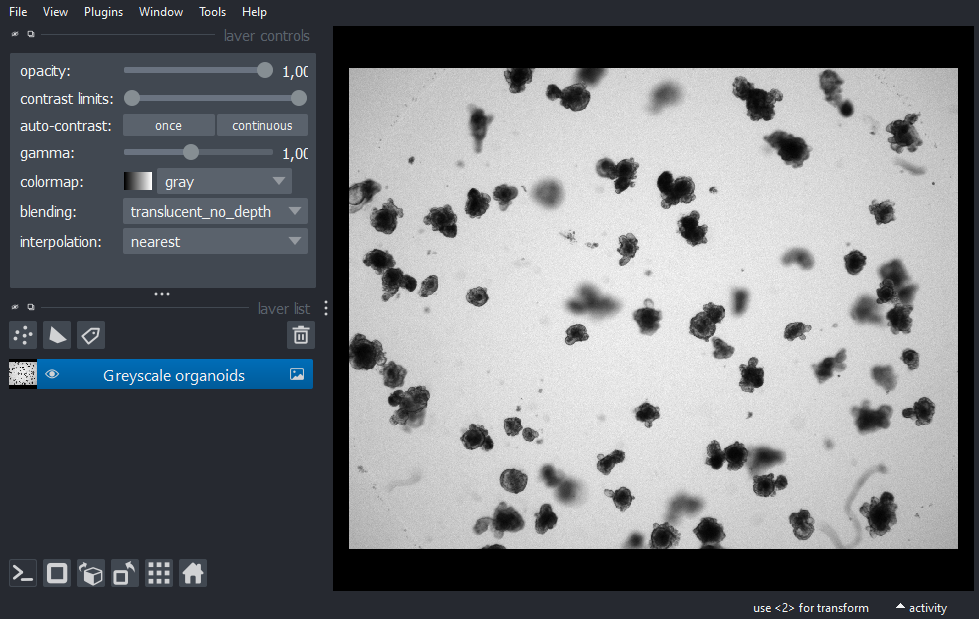

train ObjectSegmenter
num images 1
object annotation value 2
features gaussian_blur=1 difference_of_gaussian=1 laplace_box_of_gaussian_blur=1 sobel_of_gaussian_blur=1
depth 2
num trees 100
file c:/Users/albertds/Python_scripts/intestinal_organoid_brightfield_analysis/ObjectSegmenter.cl
annotation shape (1048, 1328)
Training done. Applying model...
Applying / prediction done.
train ObjectSegmenter
num images 1
object annotation value 2
features gaussian_blur=1 difference_of_gaussian=1 laplace_box_of_gaussian_blur=1 sobel_of_gaussian_blur=1
depth 2
num trees 100
file c:/Users/albertds/Python_scripts/intestinal_organoid_brightfield_analysis/ObjectSegmenter.cl
annotation shape (1048, 1328)
Training done. Applying model...
Applying / prediction done.


In [6]:
# Load one image and transform it into grayscale for APOC if needed
rgb_img = tifffile.imread(images_per_well["A01"][5], is_ome = False)
if rgb_img.shape[2] == 3:
    img = rgb2gray(rgb_img)
else:
    img = rgb_img
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(img, name="Greyscale organoids")
nbscreenshot(viewer)

<h2>Train your APOC Organoid Object Segmenter</h2>

Once the greyscale image has been opened on the Napari viewer you are ready to train the organoid object classifier. Then follow the next steps:

1. Click on the **labels layer** on Napari to create a new label where you will paint some lines over your classes of interest (background and organoids).
2. Select the paintbrush tool to paint over the Labels layer.
3. Change the brush size to 5 (depending on your image, in general the thinner the lines the better). Note you are in label 1 (brown by default), we will use this to define the background class. Paint some lines over the background and around the organoids.
4. Create a new class by clicking on the plus sign and paint over the organoids (choose in-focus and out-of-focus ones). Define the central areas and the edges.

![Napari_screenshot](./images/organoid_labeled_layer.png)





Once you're done scribbling over your image, on Napari upper menu go to <code>Tools > Segmentation-Labeling > Object Segmentation (APOC)</code>. Then follow the next steps:

1. Select your greyscale organoids as the images used for training.
2. Under the training tab select your Labels layer as the ground truth annotation.
3. Choose 2 as the object class. 2 is the label you have used to annotate the organoids (in blue).
4. Hit train!

![Napari_screenshot](./images/APOC_organoid_labels_layer.png)

After clicking train you should see the following result. After training, Napari will generate an **ObjectSegmenter.cl** file inside your root folder. The next cell will load said file and apply the segmentation to your image. Check if it makes sense, you can correct the segmentation by going back to the Labels layer where you annotated the ground truth (brown and blue lines) and adding/erasing lines accordingly. Then click on the Object segmentation (APOC) right side panel click on Train again.

![Napari_screenshot](./images/APOC_organoid_segmented.png)

In [9]:
# Apply object segmenter from APOC
segmenter = ObjectSegmenter(opencl_filename="./ObjectSegmenter.cl")
result = segmenter.predict(image=img)
viewer.add_labels(result, name="Pre-processed organoid labels")
# Remove previous layers from the visualization
viewer.layers[-2].visible = False
viewer.layers[-3].visible = False

In [10]:
# Closing some holes in the organoid labels
closed_labels = cle.closing_labels(result, None, radius=4.0)
# closed_labels = np.array(closed_labels, dtype=np.int32) # Change dtype of closed labels to feed array into nsbatwm.split
viewer.add_labels(closed_labels, name='Closed organoid labels (clesperanto)')
# Remove previous layers from the visualization
viewer.layers[-2].visible = False

The next cell will allow you to visualize the segmented objects' area in pixels, this way you can manually select a threshold to remove unwanted small objects (debris)

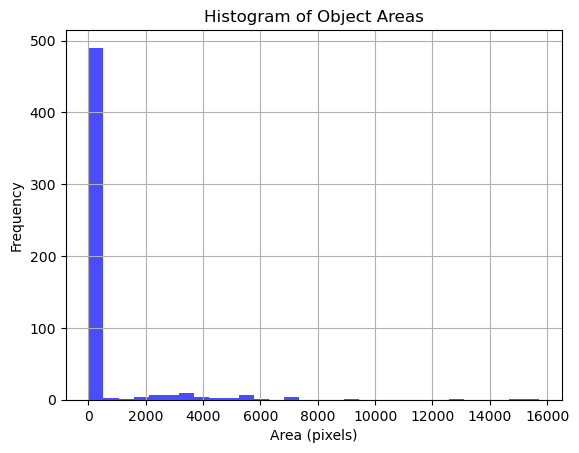

In [11]:
# Calculate and plot the area of each object to select a threshold to remove small objects
# and keep just the organoids
props = measure.regionprops(closed_labels) # Calculate the area of each labeled object

# Extract area values
area_values = [prop.area for prop in props]

# Create and display the histogram
plt.hist(area_values, bins=30, color='b', alpha=0.7)
plt.xlabel('Area (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of Object Areas')
plt.grid(True)
plt.show()

The cell below allows you to tune the threshold to remove small objects, by default anything below 1000px in area will be removed from the segmented objects list

In [12]:
# Exclude small labels, cutout in pixel area seems to be below 1000px
exclude_small = cle.exclude_small_labels(closed_labels, None, 1000.0)
exclude_small = np.array(exclude_small, dtype=np.int32) # Change dtype of closed labels to feed array into nsbatwm.split
viewer.add_labels(exclude_small, name='Excluded small labels (clesperanto)')
# Remove previous layers from the visualization
viewer.layers[-2].visible = False


At this point you should see something like this

![Napari_screenshot](./images/remove_small_objects.png)

The next cell will split organoids that are close to each other and wrongly segmented as one single object. You can play with the sigma value to see the effect on splitting.

In [13]:
# Splitting organoids into a binary mask
split_organoids = nsbatwm.split_touching_objects(exclude_small, sigma=10.0)
viewer.add_labels(split_organoids, name='Splitted touching organoids (nsbatwm)')

<Labels layer 'Splitted touching organoids (nsbatwm)' at 0x29616709f70>

![Napari_screenshot](./images/binary_split_organoids.png)

Below we will convert the binary mask of separated organoids into single objects again.

In [14]:
# Connected component (cc) labeling
cc_split_organoids = nsbatwm.connected_component_labeling(split_organoids, False)
viewer.add_labels(cc_split_organoids, name='Connected component organoids (scikit-image, nsbatwm)')
# Remove previous layers from the visualization
viewer.layers[-2].visible = False
viewer.layers[-3].visible = False

![Napari_screenshot](./images/processed_organoid_objects.png)

<h2>Train your APOC Organoid Object Classifier</h2>

The next steps will allow us to train the object classifier that is necessary to tell organoids in-focus from out-of-focus organoids. 

1. Create a new Labels layer.
2. Double click on it and rename it as Focus labels. Hide the Connected components label by clicking-on the eye icon.
3. Draw brown lines (label 1) over out of focus organoids. Remember the thinner the lines the better (brush size <=5)
4. Increase label id to 2 by cliking on the + sign and draw over in-focus organoids.

You should end up with something looking like this:

![Napari_screenshot](./images/organoid_focus_labeled_layer.png)

Once you are happy with the amount of labelling (you do not need much) on Napari upper menu go to <code>Tools > Segmentation post-processing > Object Classification (APOC)</code>. Then follow the next steps:

1. On the Labels tab choose Connected component organoids as the layer we will apply the object classifier to.
2. Under the Training tab choose Focus labels as the annotation. Then click on all the options displayed in the screenshot below.
3. Hit Train.

![Napari_screenshot](./images/APOC_organoid_focus_labels_layer.png)

After clicking train you should see the following result. After training, Napari will generate an **ObjectClassifier.cl** file inside your root folder. The next cell will load said file and apply the classification to your organoid objects. Check if it makes sense, you can correct the segmentation by going back to the Focus Labels layer where you annotated the ground truth (brown and blue lines) and adding/erasing lines accordingly.

![Napari_screenshot](./images/APOC_organoids_focus_classified.png)

In [ ]:
# Apply object classifier from APOC
classifier = ObjectClassifier(opencl_filename="./ObjectClassifier.cl")
result = classifier.predict(labels=cc_split_organoids, image=img)
viewer.add_labels(result, name="Focus and out of focus organoids")
# Remove previous layers from the visualization
viewer.layers[-2].visible = False
viewer.layers[-3].visible = False


<h2>ObjectClassifier and Segmenter are ready!</h2>

At this point you should have generated the classifier and segmenter files needed to run the second Jupyter notebook [2_find_focus_and_store](./2_find_focus_and_store.ipynb) that will allow you to analyze your stack of images and choose the one with the highest number of organoids in focus.

In [ ]:
# Convert the resulting .cle image into a np.array to count objects within each class

image_array = np.array(result, dtype=np.int8)
# Create masks for each class
out_of_focus_mask = image_array == 1
in_focus_mask = image_array == 2

# Label connected components in each mask
out_of_focus_labels = measure.label(out_of_focus_mask, connectivity=2)
in_focus_labels = measure.label(in_focus_mask, connectivity=2)

# Calculate the number of objects in each class
num_out_of_focus_objects = np.max(out_of_focus_labels)
num_in_focus_objects = np.max(in_focus_labels)

print(f"Number of Out-of-Focus Objects: {num_out_of_focus_objects}")
print(f"Number of In-Focus Objects: {num_in_focus_objects}")